# Үй жұмысы: Модель сапасын арттыру және теңгерімсіз кластар

**Тақырыбы:** Банк клиенттерінің кетуін болжау (Churn Prediction).

**Мақсаты:**

1. Деректерді талдау және өңдеу.
2. Модель сапасының метрикаларын (Precision, Recall, F1, ROC-AUC) түсіну.
3. Теңгерімсіз кластармен жұмыс істеу (Class Weight, SMOTE).
4. Гиперпараметрлерді оңтайландыру (GridSearch/RandomSearch).

**Деректер жиынтығы:** "Bank Customer Churn" датасетін қолданамыз. Бұл деректер клиенттің банк қызметінен бас тарту ықтималдығын болжайды.








## 1. Қысқаша теория

Бұл жұмыста келесі ұғымдар қолданылады:

* **Теңгерімсіз деректер (Imbalanced Data):** Бір класс өкілдері екіншісінен әлдеқайда көп болған жағдай (мысалы, клиенттердің 80%-ы қалды, тек 20%-ы кетті). Мұнда қарапайым `Accuracy` метрикасы алдамшы болады.
* **Precision (Дәлдік):** Модель "кетті" деп болжағандардың қаншасы шынымен кетті?
* **Recall (Толықтық):** Шынымен кеткендердің қаншасын модель таба алды?
* **F1-Score:** Precision мен Recall-дың орташа гармоникалық мәні.
* **SMOTE (Synthetic Minority Over-sampling Technique):** Аз класты жасанды түрде көбейту әдісі.
* **GridSearchCV:** Модельдің ең жақсы параметрлерін (мысалы, ағаш тереңдігін) автоматты түрде іздеу.

In [1]:
# Қажетті кітапханаларды импорттау
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn модульдері
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score

# Теңгерімсіздікпен жұмыс (егер орнатылмаған болса: !pip install imbalanced-learn)
from imblearn.over_sampling import SMOTE

# Ескертулерді өшіру
import warnings
warnings.filterwarnings('ignore')

# Графиктер стилі
sns.set(style="whitegrid")


## 2. Деректерді жүктеу және шолу

Біз `Churn_Modelling.csv` файлын тікелей GitHub репозиторийінен жүктейміз.

In [2]:
# Деректерді оқу
url = "https://raw.githubusercontent.com/sharmaroshan/Churn-Modelling-Dataset/master/Churn_Modelling.csv"
df = pd.read_csv(url)

# Алғашқы 5 жолды көрсету
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Деректер жиынтығының ақпаратын шығару

In [3]:
# Деректер жиынтығының ақпаратын шығару
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB



### Тапсырма 1: Мақсатты айнымалыны талдау

`Exited` бағаны — біздің мақсатты айнымалымыз (0 - қалды, 1 - кетті). Кластардың арақатынасын тексеріңіз.


Кластардың саны:
Exited
0    7963
1    2037
Name: count, dtype: int64

Кластардың пайызы:
Exited
0    79.63
1    20.37
Name: proportion, dtype: float64


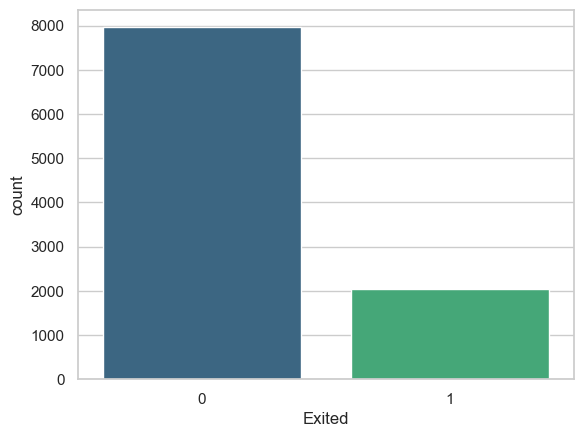

In [ ]:
# TODO: 'Exited' бағанындағы кластардың санын және пайызын шығарыңыз.
# Көмек: value_counts(normalize=True) қолданыңыз.

# -- СІЗДІҢ КОДЫҢЫЗ ОСЫ ЖЕРДЕ --

exited_count = df['Exited'].value_counts()

sns.countplot(x = df['Exited'], palette='viridis')

print("Кластардың саны:")
print(df['Exited'].value_counts())
print("\nКластардың пайызы:")
print(df['Exited'].value_counts(normalize=True) * 100)

<details>
<summary>💡 Жауабын көру</summary>
<br>

Жауап.

```python
# дұрыс код:
print("Кластардың саны:")
print(df['Exited'].value_counts())
print("\nКластардың пайызы:")
print(df['Exited'].value_counts(normalize=True) * 100)


## 3. Деректерді алдын-ала өңдеу (Preprocessing)

Модельге сандық емес мәндерді (мәтін) беруге болмайды. Сондай-ақ, идентификаторлар (ID, аты-жөні) болжамға қатыспауы керек.


In [13]:
# Қажет емес бағандарды алып тастау
# RowNumber, CustomerId, Surname - бұл бағандар модельге пайдасыз
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

# Тексеру
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0




### Тапсырма 2: Категориялық айнымалыларды кодтау

`Geography` және `Gender` бағандарын сандық форматқа айналдыру керек. Ол үшін `pd.get_dummies` қолданыңыз (One-Hot Encoding).


In [16]:
# TODO: pd.get_dummies функциясын қолданып, категориялық бағандарды кодтаңыз.
# drop_first=True параметрін қолдану ұсынылады (multicollinearity болдырмау үшін).

# -- СІЗДІҢ КОДЫҢЫЗ ОСЫ ЖЕРДЕ --

df_encoded = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)
print("\nEncoded data:")
df_encoded.head()


Encoded data:


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,True,False
2,502,42,8,159660.80,3,1,0,113931.57,1,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,0,False,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0,False,True,False


<details>
<summary>💡 Жауабын көру</summary>
<br>

Жауап.

```python
# дұрыс код:
df_encoded = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)
print("\nКодталған деректер:")
df_encoded.head()



### Тапсырма 3: Деректерді бөлу (Train/Test Split)

Деректерді `X` (белгілер) және `y` (мақсат) деп бөліп, кейін оларды жаттықтыру (80%) және тестілеу (20%) жиындарына ажыратыңыз. `stratify=y` параметрін қолдануды ұмытпаңыз.


In [17]:
# X және y бөлу (TODO орындалғаннан кейін df_encoded қолданыңыз)
# X = df_encoded.drop('Exited', axis=1)
# y = df_encoded['Exited']

# TODO: train_test_split функциясын қолданыңыз (test_size=0.2, random_state=42)

# -- СІЗДІҢ КОДЫҢЫЗ ОСЫ ЖЕРДЕ --

X = df_encoded.drop('Exited', axis=1)
y = df_encoded['Exited']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


Train set: (8000, 11)
Test set: (2000, 11)


<details>
<summary>💡 Жауабын көру</summary>
<br>

Жауап.

```python
# дұрыс код:
X = df_encoded.drop('Exited', axis=1)
y = df_encoded['Exited']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain жиын: {X_train.shape}")
print(f"Test жиын: {X_test.shape}")

## 4. Базалық модель (Baseline Model)

Алдымен ешқандай баптаусыз `RandomForestClassifier` құрып, оның нәтижесін көрейік.



In [18]:
# Деректерді масштабтау (RandomForest үшін міндетті емес, бірақ жақсы практика)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Модельді құру және оқыту
rf_base = RandomForestClassifier(random_state=42)
rf_base.fit(X_train_scaled, y_train)

# Болжам жасау
y_pred_base = rf_base.predict(X_test_scaled)

# Нәтижені шығару
print("--- Базалық модель нәтижелері ---")
print(classification_report(y_test, y_pred_base))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_base):.4f}")

--- Базалық модель нәтижелері ---
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1593
           1       0.78      0.46      0.58       407

    accuracy                           0.86      2000
   macro avg       0.83      0.71      0.75      2000
weighted avg       0.86      0.86      0.85      2000

ROC-AUC Score: 0.7134



**Талдау:** 1-класс (кеткен клиенттер) үшін `Recall` метрикасына назар аударыңыз. Ол төмен болуы мүмкін, себебі деректер теңгерімсіз.




## 5. Теңгерімсіз кластармен жұмыс (Handling Imbalance)

### 1-әдіс: Class Weight

Модельге аз кездесетін кластың "құнын" арттыруды бұйырамыз.


In [24]:

# TODO: RandomForestClassifier ішінде class_weight='balanced' параметрін қолданып, жаңа модель оқытыңыз.
# Модель атауын rf_weighted деп қойыңыз.

# -- СІЗДІҢ КОДЫҢЫЗ ОСЫ ЖЕРДЕ --

rf_weighted = RandomForestClassifier(class_weight='balanced', random_state=42, max_depth=150)
rf_weighted.fit(X_train_scaled, y_train)

y_pred_weighted = rf_weighted.predict(X_test_scaled)
print(classification_report(y_test, y_pred_weighted))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1593
           1       0.78      0.44      0.56       407

    accuracy                           0.86      2000
   macro avg       0.83      0.70      0.74      2000
weighted avg       0.85      0.86      0.85      2000



<details>
<summary>💡 Жауабын көру</summary>
<br>

Жауап.

```python
# дұрыс код:
rf_weighted = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_weighted.fit(X_train_scaled, y_train)

y_pred_weighted = rf_weighted.predict(X_test_scaled)
print(classification_report(y_test, y_pred_weighted))


### 2-әдіс: SMOTE (Synthetic Minority Over-sampling Technique)

Аз кездесетін класты синтетикалық жолмен көбейту.

**Ескерту:** SMOTE тек `X_train` жиынына қолданылуы керек! `X_test` жиынына тиісуге болмайды.



In [27]:

# TODO: SMOTE қолданып, X_train_scaled және y_train деректерін теңестіріңіз.
# random_state=42 қолданыңыз.

# -- СІЗДІҢ КОДЫҢЫЗ ОСЫ ЖЕРДЕ --

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(y_train_smote.value_counts())

Exited
1    6370
0    6370
Name: count, dtype: int64


<details>
<summary>💡 Жауабын көру</summary>
<br>

Жауап.

```python
# дұрыс код:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(y_train_smote.value_counts())

In [28]:
# SMOTE деректерінде модельді оқыту
rf_smote = RandomForestClassifier(random_state=42)
rf_smote.fit(X_train_smote, y_train_smote)

# Болжам жасау (Тест деректері өзгеріссіз қалуы керек!)
y_pred_smote = rf_smote.predict(X_test_scaled)

print("--- SMOTE нәтижелері ---")
print(classification_report(y_test, y_pred_smote))

--- SMOTE нәтижелері ---
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1593
           1       0.62      0.59      0.60       407

    accuracy                           0.84      2000
   macro avg       0.76      0.75      0.75      2000
weighted avg       0.84      0.84      0.84      2000





## 6. Гиперпараметрлерді іріктеу (Optimization)

Енді `GridSearchCV` көмегімен модельдің ең жақсы параметрлерін табайық. Біз SMOTE қолданылған деректерді немесе `class_weight` әдісін негізге ала аламыз.



In [29]:

# TODO: Іздеуге қажетті параметрлер торын (param_grid) құрыңыз.
# Келесі параметрлерді қосыңыз:
# 'n_estimators': [100, 200],
# 'max_depth': [10, 20, None],
# 'min_samples_split': [2, 5]

# -- СІЗДІҢ КОДЫҢЫЗ ОСЫ ЖЕРДЕ --

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

<details>
<summary>💡 Жауабын көру</summary>
<br>

Жауап.

```python
# дұрыс код:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)


In [ ]:
# Іздеуді бастау (SMOTE деректерінде немесе бастапқы train деректерінде)
# grid_search.fit(X_train_smote, y_train_smote)

# Ең жақсы нәтижелер
# print("Ең үздік параметрлер:", grid_search.best_params_)


grid_search.fit(X_train_smote, y_train_smote)

print("\nЕң үздік параметрлер:", grid_search.best_params_)
print("Ең үздік F1-score:", grid_search.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits

Ең үздік параметрлер: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Ең үздік F1-score: 0.8939244071213323


<details>
<summary>💡 Жауабын көру</summary>
<br>

Жауап.

```python
# дұрыс код:
grid_search.fit(X_train_smote, y_train_smote)

print("\nЕң үздік параметрлер:", grid_search.best_params_)
print("Ең үздік F1-score:", grid_search.best_score_)


## 7. Қорытынды бағалау

Ең үздік деп табылған модельмен соңғы тестілеуді жүргіземіз.


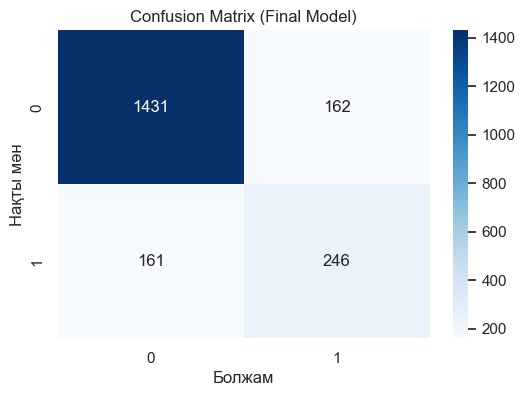

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1593
           1       0.60      0.60      0.60       407

    accuracy                           0.84      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.84      0.84      0.84      2000



In [31]:
# Үздік модельді алу
best_model = grid_search.best_estimator_

# Соңғы болжам
y_final_pred = best_model.predict(X_test_scaled)

# Қателіктер матрицасы
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_final_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Final Model)')
plt.ylabel('Нақты мән')
plt.xlabel('Болжам')
plt.show()

# Метрикалар
print(classification_report(y_test, y_final_pred))



**Сұрақ:** Сіздің ойыңызша, банк үшін қай қателік ауырлау?

1. Кететін клиентті "қалады" деп болжау (False Negative).
2. Қалатын клиентті "кетеді" деп болжау (False Positive).
